In [1]:
# 全局设置
import sys
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../../config/HDF5DBConfig.json").connect();

择时策略给出每一期针对某证券的仓位水平. 定义择时策略的信号格式为: Series(-inf~inf 的仓位水平(float)或者 nan 表示维持目前仓位, index=[ID]) 或者 None(表示无信号, 默认值), Strategy.genSignal() 方法的返回值必须遵守以上约定.

每个 ID 择时信号取值的可能范围及其含义:
* `=0` 表示清空所有头寸;
* `>0` 表示做多, 取值为 1 表示满仓, <1 表示有资金剩余, >1 表示加杠杆做多;
* `<0` 表示做空, 取值为 -1 表示满仓, >-1 表示空头头寸金额小于分配到的资金, <-1 表示加杠杆做空;
* `nan` 表示维持当前头寸规模

用户实现的择时策略类应该继承自 Strategy.TimingStrategy, 并实现其 TimingStrategy.genSignal() 方法, 返回择时信号, 格式必须满足上述要求.

这里以一个简单的均线交叉策略作为示例, 每个时点计算长期均线 LMA, 短期均线 SMA 的值, 策略的逻辑为:
* 当 SMA 向上突破 LMA 时, 如果当时持有空仓, 则先平仓, 再开多仓; 如果没有仓位, 则直接开多仓;
* 当 SMA 向下突破 LMA 时, 如果当时持有多仓, 则先平仓, 再开空仓; 如果没有仓位, 则直接开空仓;
* 在每个月月底重新再平衡所有 ID 的资金权重为等权

==========历史回测==========
1. 初始化


  0% (0 of 1299) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

耗时 : 8.37
2. 循环计算


100% (1299 of 1299) |####################| Elapsed Time: 0:01:22 Time:  0:01:22


耗时 : 82.56
3. 结果生成
耗时 : 0.28
总耗时 : 91.22


,绝对表现
起始时点,2014-01-02
结束时点,2019-04-30
时点数,1299
总收益率,101.69%
年化收益率,14.08%
年化波动率,16.32%
Sharpe比率,0.86
收益风险比,0.86
胜率,75.75%
最大回撤率,37.26%

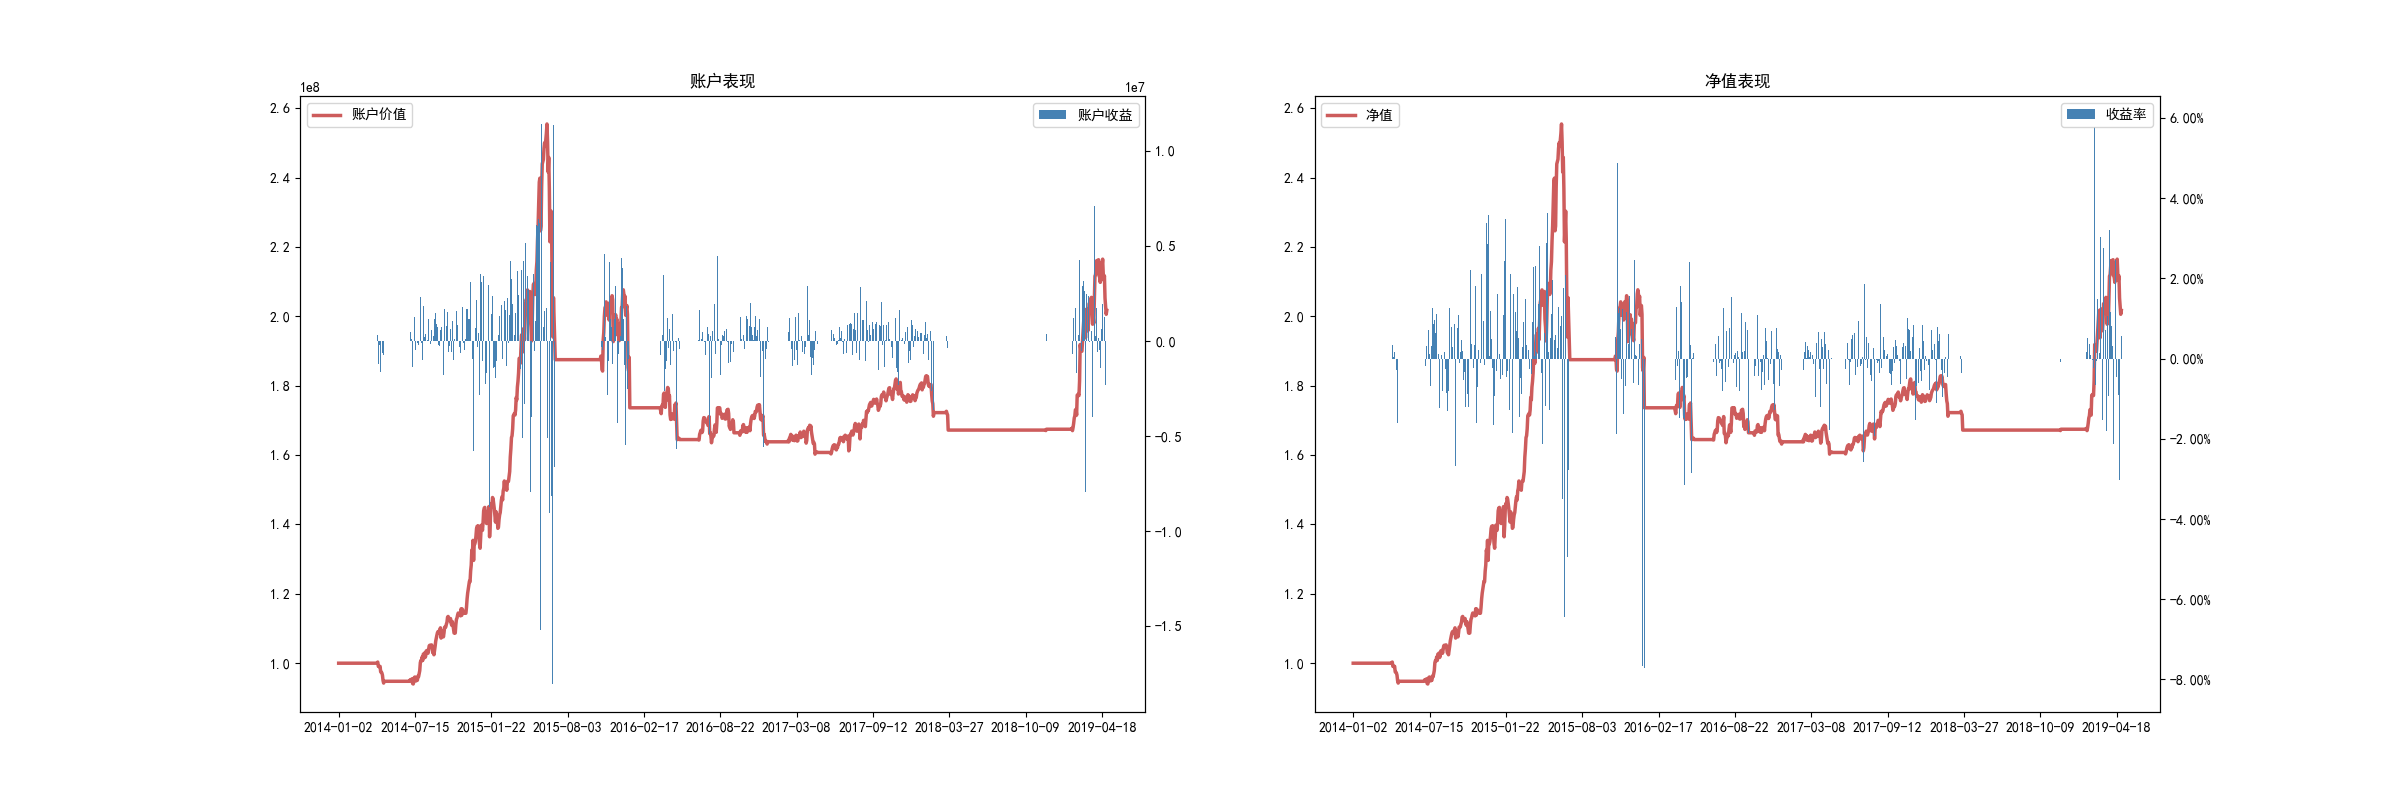

In [3]:
# 均线交叉策略
# 计算:
# (1) NL 期长期均线 LMA;
# (2) NS 期短期均线 SMA;
# 交易逻辑:
# (1) 当 SMA 向上突破 LMA 时, 如果当时持有空仓, 则先平仓, 再开多仓; 如果没有仓位, 则直接开多仓;
# (2) 当 SMA 向下突破 LMA 时, 如果当时持有多仓, 则先平仓, 再开空仓; 如果没有仓位, 则直接开空仓;
# (3) 在每个月月底重新再平衡所有 ID 的资金权重为等权
class MACrossStrategy(QS.BackTest.Strategy.TimingStrategy):
    def genSignal(self, idt, trading_record):
        TargetIDs = self.TargetIDs
        if self.Model.DateTimeIndex<self.ModelArgs["NL"]: return None
        DTs = self.Model.DateTimeSeries[-self.ModelArgs["NL"]-1:]
        Price = self.MainFactorTable.readData(factor_names=["close"], ids=TargetIDs, dts=DTs).iloc[0]
        LMA = Price.rolling(window=self.ModelArgs["NL"]).mean()
        SMA = Price.rolling(window=self.ModelArgs["NS"]).mean()
        Signal = pd.Series(np.nan, index=TargetIDs)
        if idt in self.ModelArgs["再平衡时点"]:
            self.Args["资金分配"] = pd.Series(self.Args["目标账户"].AccountValue/len(TargetIDs), index=TargetIDs)
            Signal[SMA.iloc[-1]>LMA.iloc[-1]] = 1
            Signal[SMA.iloc[-1]<LMA.iloc[-1]] = -1
        else:
            Signal[(SMA.iloc[-2]<=LMA.iloc[-2]) & (SMA.iloc[-1]>LMA.iloc[-1])] = 1
            Signal[(SMA.iloc[-2]>=LMA.iloc[-2]) & (SMA.iloc[-1]<LMA.iloc[-1])] = -1
        return Signal

# 创建自定义因子表
FT = HDB.getTable("index_cn_day_bar")
FT.Args["遍历模式"]["向后缓冲时点数"] = 60# 增加缓冲区向后缓冲的时点数, 保证缓冲区里有足够的历史时间序列
DTs = FT.getDateTime(ifactor_name="close", start_dt=dt.datetime(2014, 1, 1), end_dt=dt.datetime(2019, 4, 30))
IDs = ["000300.SH", "000905.SH"]

# 创建回测模型
Model = QS.BackTest.BackTestModel()

iAccount = QS.BackTest.Strategy.DefaultAccount(market_ft=FT)
iAccount.Args["初始资金"] = 1e8
iAccount.Args["负债上限"] = 0.0
iAccount.Args["交易延迟"] = False
iAccount.Args["目标ID"] = IDs
iAccount.Args["买入限制"]["交易费率"] = 0.00
iAccount.Args["卖出限制"]["交易费率"] = 0.00
iAccount.Args["卖出限制"]["允许卖空"] = False
iAccount.Args["最新价"] = "close"

iModule = MACrossStrategy(name="MACrossStrategy", factor_table=FT)
iModule.Args["目标账户"] = iAccount
iModule.Args["资金分配"] = pd.Series(1e8/len(IDs), index=IDs)
iModule.ModelArgs["NL"] = 60
iModule.ModelArgs["NS"] = 10
iModule.ModelArgs["再平衡时点"] = QS.Tools.DateTime.getMonthLastDateTime(DTs)
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 查看结果
display(Model)